# WICCA: Wavelet-based Image Compression & Classification Analysis

WICCA is a research framework exploring the impact of wavelet compression on image classification performance.
The goal is to assess whether reducing image size via Haar wavelet transformation retains enough information for accurate classification.

### Objectives
- Apply Haar wavelet compression to large images (>2K resolution).
- Evaluate classification performance on both original and compressed images.
- Compare results across multiple pre-trained models.


# Imports

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras.applications as apps
from settings.constants import SIM_CLASSES, SIM_CLASSES_PERC, SIM_BEST_CLASS

import contextlib
import concurrent.futures
import io

import utility.result_manager as resmgr
from utility.data_loader import load_image
from utility.wavelet_coder import HaarCoder
# from utility.result_manager import load_summary_results, get_short_comparison
from utility.classifying_tools import classify_images_n_icons_from_folder, load_classifier

%matplotlib inline

Load a sample image before and after Haar compression

# Models
Trained image classifiers: https://keras.io/api/applications/

In [2]:
classifiers = {
    'MobileNetV2': load_classifier(apps.mobilenet_v2.MobileNetV2),
    'VGG16': load_classifier(apps.vgg16.VGG16),
    'VGG19': load_classifier(apps.vgg19.VGG19),
    'ResNet50': load_classifier(apps.resnet50.ResNet50),
    'NASNetMobile': load_classifier(apps.nasnet.NASNetMobile),
    'NASNetLarge': load_classifier(apps.nasnet.NASNetLarge, shape=(331, 331))
}

# Data

In [3]:
path = 'data\orig'
list_dir = os.listdir(path)
print('Number of images:', len(list_dir))

Number of images: 130


Text(0.5, 1.0, 'pp_03.jpg, shape: (6350, 9588, 3)')

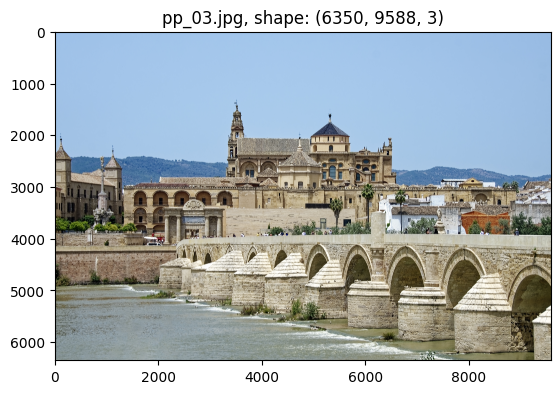

In [4]:
# Sample
index = 2

name = list_dir[index]
# sample = load_image(f'{drive_path}/{name}')
sample = load_image(f'{path}/{name}')

plt.imshow(sample)
plt.title(f'{name}, shape: {sample.shape}')

This is for future side to side visualization of large image and its icon

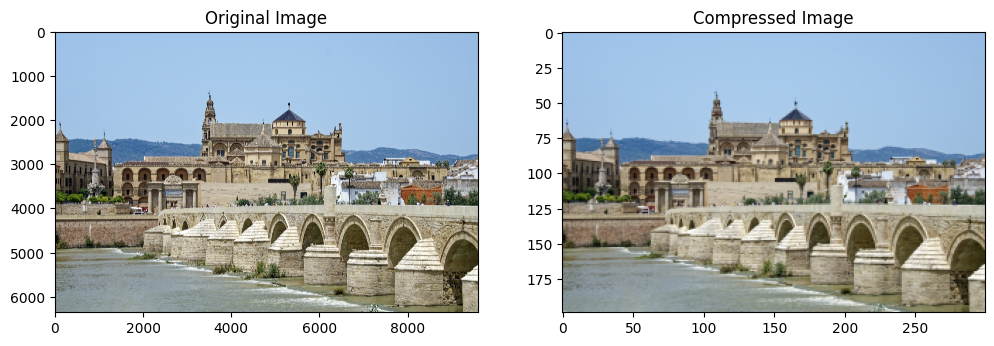

Original size: (6350, 9588, 3)
Compressed size: (199, 300, 3)


In [8]:
def show_image_n_icon(image):
    # Load a sample image before and after Haar compression

    # image_path = "data/orig/pp_00.jpg"
    # original = load_image(image_path)
    original = image
    # coder = HaarCoder()
    compressed = coder.get_small_copy(
        image=original,
        transform_depth=5
    )
    # Display original vs. compressed
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    axes[0].imshow(original), axes[0].set_title("Original Image")
    axes[1].imshow(compressed), axes[1].set_title("Compressed Image")
    plt.show()
    # Print image statistics
    print(f"Original size: {original.shape}")
    print(f"Compressed size: {compressed.shape}")

show_image_n_icon(sample)


# Analysis

In [6]:
coder = HaarCoder() # defines our wavelet
depth = 5 # defines the depth of transforming
top = 5 # defines top classes for comparison

# type of interpolation used in resizing
interpolation = cv2.INTER_AREA

# Define the results folder
results_folder = os.path.join("results", f"depth_{depth}")
os.makedirs(results_folder, exist_ok=True)

We can say this is one of the core functions in the framework that starts our analysis.
Actually, I am going to implement some better error handling and work more with the timer. For now, the timer just shuts down the whole process and does not take into consideration what classifiers are currently working.

In [7]:
def process_classifier(item):
    name, classifier = item
    res = classify_images_n_icons_from_folder(classifier, path, coder, depth, interpolation)
    res_df = resmgr.get_short_comparison(res, top)

    # Save CSV files inside the "results" folder
    res_df.to_csv(os.path.join(results_folder, f"{name}-depth_{depth}.csv"))
    sum_df = res_df.describe()
    sum_df.to_csv(os.path.join(results_folder, f"{name}-summary-depth_{depth}.csv"))

    return name, sum_df

# with contextlib.redirect_stdout(io.StringIO()): #silencing output (wrong way)
with concurrent.futures.ThreadPoolExecutor() as executor: # processing multiple classifiers in parallel
    try:
        results = dict(executor.map(process_classifier,
                                    classifiers.items(),
                                    timeout=3600))  # 1 hour timeout
    except concurrent.futures.TimeoutError:
        print("Processing timed out")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

1/1 [==============================] - 0s 485ms/step


## For current depth
Let's look on classifying comparison with one certain depth

### MobileNetV2

In [7]:
resmgr.load_summary_results(depth, 'MobileNetV2', True)


Summary for MobileNetV2 at depth 5:
Shape: (8, 4)
Columns: ['Unnamed: 0', 'similar classes (count)', 'similar classes (%)', 'similar best class']
First few rows:


,Unnamed: 0,similar classes (count),similar classes (%),similar best class
0,count,130.000000,130.000000,130.000000
1,mean,4.046154,80.923077,0.761538
2,std,0.745649,14.912986,0.427791
3,min,2.000000,40.000000,0.000000
4,25%,4.000000,80.000000,1.000000
5,50%,4.000000,80.000000,1.000000
6,75%,5.000000,100.000000,1.000000
7,max,5.000000,100.000000,1.000000


### VGG16

In [8]:
results['VGG16']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.507692,90.153846,0.815385
std,0.649939,12.998784,0.389486
min,2.000000,40.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,5.000000,100.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### VGG19

In [9]:
results['VGG19']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.584615,91.692308,0.876923
std,0.581159,11.623183,0.329796
min,2.000000,40.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,5.000000,100.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### ResNet50

In [10]:
results['ResNet50']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.323077,86.461538,0.861538
std,0.706727,14.134544,0.346720
min,2.000000,40.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,4.000000,80.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### NASNetMobile

In [11]:
results['NASNetMobile']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.392308,87.846154,0.892308
std,0.687611,13.752216,0.311191
min,2.000000,40.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,4.500000,90.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### NASNetLarge

In [12]:
results['NASNetLarge']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.238462,84.769231,0.846154
std,0.814632,16.292643,0.362197
min,1.000000,20.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,4.000000,80.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### Compare classifiers

In [11]:
names = []
mean_sim_clas_perc = []
mean_sim_best_clas = []

for name, df in results.items():
  names.append(name)
  mean_sim_clas_perc.append(df.iat[1, 1])
  mean_sim_best_clas.append(df.iat[1, 2] * 100)

### Similar classes

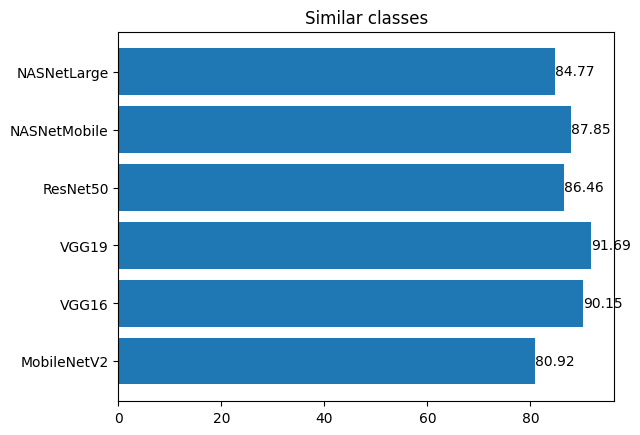

In [12]:
args = list(range(len(names)))

plt.barh(args, mean_sim_clas_perc)

for i, value in enumerate(mean_sim_clas_perc):
    plt.text(value + 0.01, i, f'{value:.2f}', va='center')

plt.yticks(args, labels=names)
plt.title('Similar classes')
plt.show()

### The best class similarity

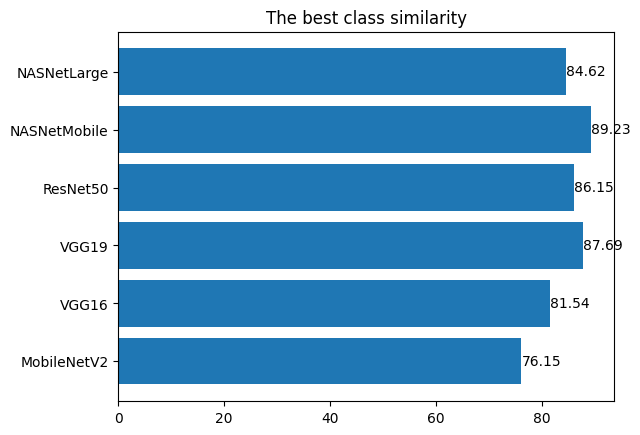

In [13]:
args = list(range(len(names)))

plt.barh(args, mean_sim_best_clas)

for i, value in enumerate(mean_sim_best_clas):
    plt.text(value + 0.01, i, f'{value:.2f}', va='center')

plt.yticks(args, labels=names)
plt.title('The best class similarity')
plt.show()

##  Results comparison for different depths
In this block we compare values by different metrics

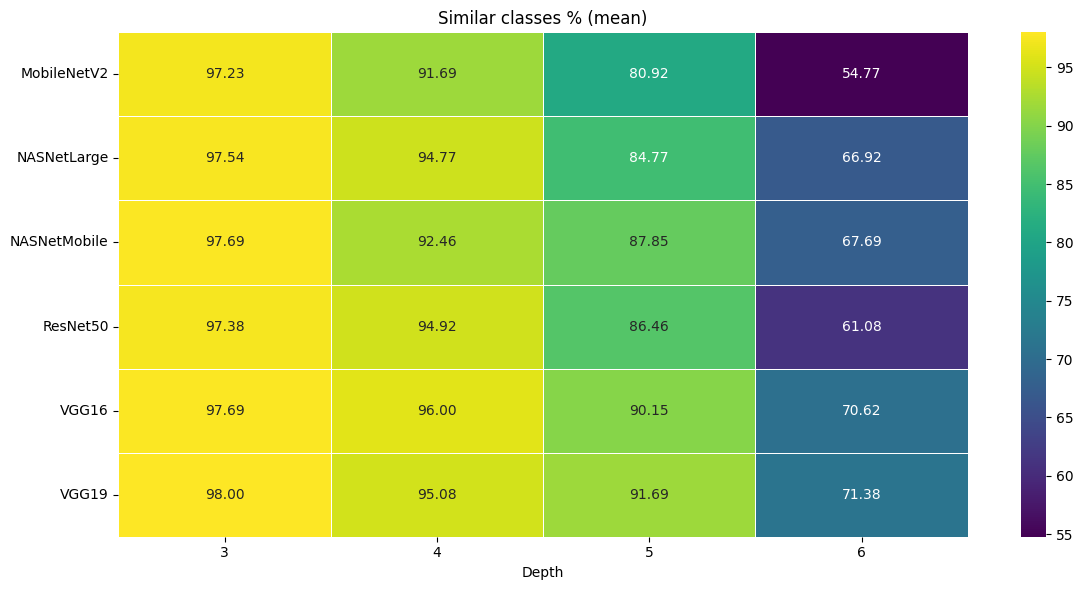

In [14]:
# classifiers = ['MobileNetV2', 'VGG16', 'VGG19', 'ResNet50', 'NASNetMobile', 'NASNetLarge']
depths = [3, 4, 5, 6]

x = resmgr.compare_summaries(classifiers, depths, "mean")
resmgr.visualize_comparison(x, SIM_CLASSES_PERC, title="Similar classes % (mean)")

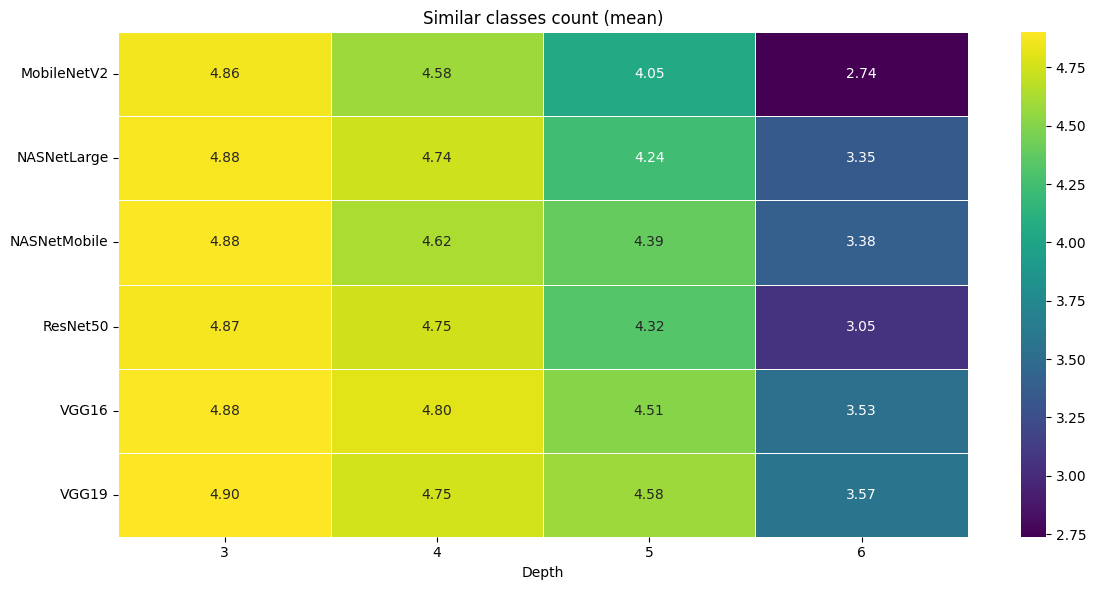

In [15]:
resmgr.visualize_comparison(x, SIM_CLASSES, title="Similar classes count (mean)")

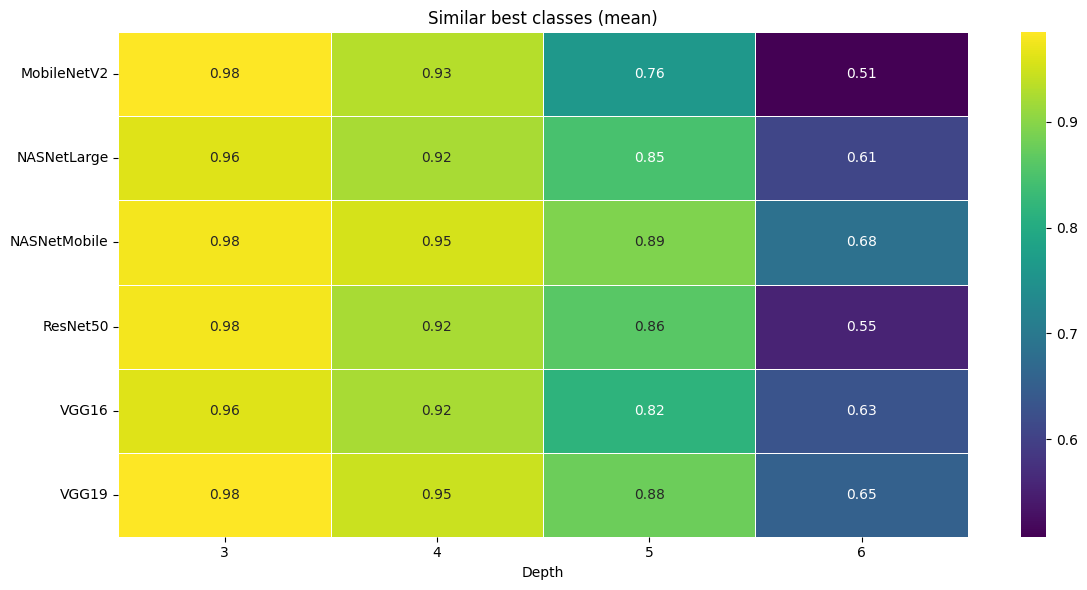

In [16]:
resmgr.visualize_comparison(x, SIM_BEST_CLASS, title="Similar best classes (mean)")

## Key Insights & Takeaways

- **Effect of Haar Compression:** The transformation significantly reduces image size but retains recognizable features.
- **Model Performance:** Some models (e.g., ResNet, NASNet) handle compressed images better than others.
- **Trade-offs:** Compression reduces computational cost but may slightly impact accuracy, depending on the classifier.
- **Next Steps:** Extend analysis to other wavelet types (Daubechies, Coiflet) and test on additional datasets.


# Conclusions
Let's look on the results for depth 5.

On average, each model:

* Produces the same best prediction class for at least 80% of cases for both source and icon images.
* Provides predictions that coincide between the source and icon images in at least 80.88% of cases.

So, in some applications, when operating large digital photos, it makes sense to apply classifier to **icon**.

REMARK. In this demo, the Haar wavelet is used. Its approximation properties are not the best. In other words, there exists better wavelet systems, and these systems might produce better icon. So, the percentage might be higher. The framework and its extension can be useful in the research.